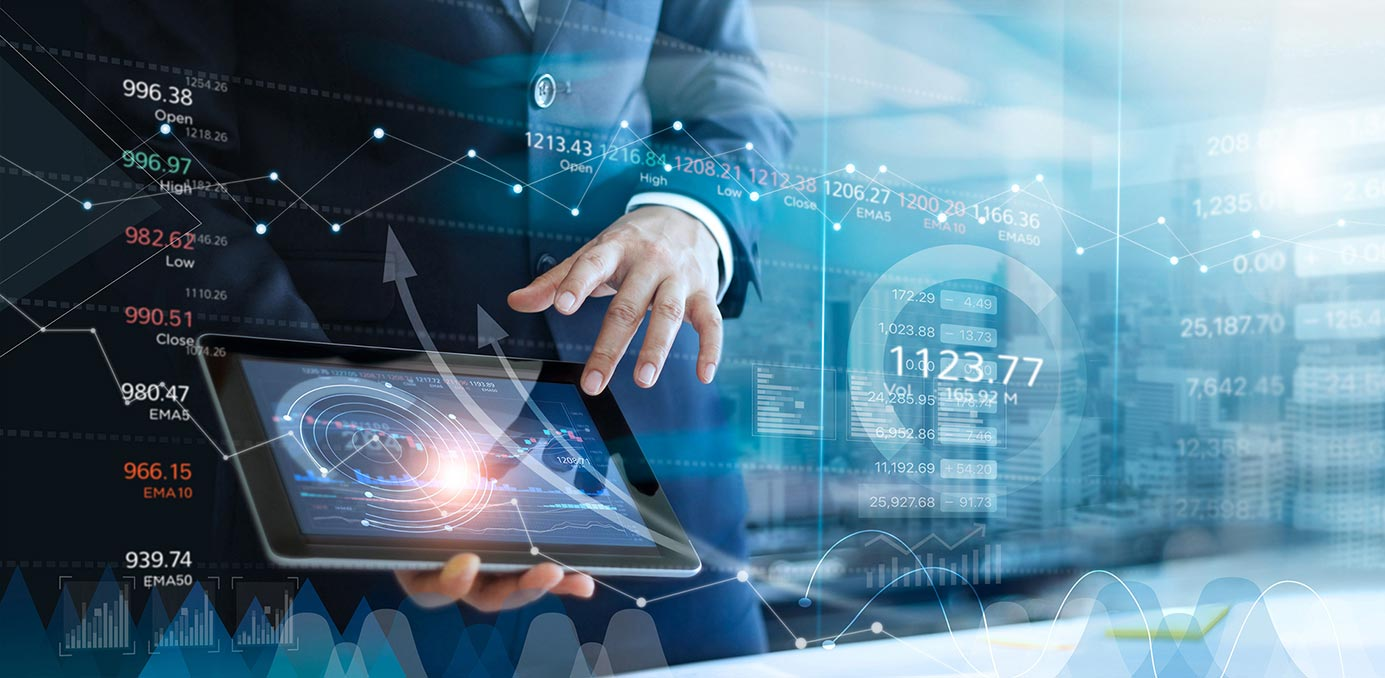

<br>

Personal loans are a lucrative revenue stream for banks. The typical interest rate of a two year loan in the United Kingdom is [around 10%](https://www.experian.com/blogs/ask-experian/whats-a-good-interest-rate-for-a-personal-loan/). This might not sound like a lot, but in September 2022 alone UK consumers borrowed [around £1.5 billion](https://www.ukfinance.org.uk/system/files/2022-12/Household%20Finance%20Review%202022%20Q3-%20Final.pdf), which would mean approximately £300 million in interest generated by banks over two years!

You have been asked to work with a bank to clean and store the data they collected as part of a recent marketing campaign, which aimed to get customers to take out a personal loan. They plan to conduct more marketing campaigns going forward so would like you to set up a PostgreSQL database to store this campaign's data, designing the schema in a way that would allow data from future campaigns to be easily imported. 

They have supplied you with a csv file called `"bank_marketing.csv"`, which you will need to clean, reformat, and split, in order to save separate files based on the tables you will create. It is recommended to use `pandas` for these tasks.

Lastly, you will write the SQL code that the bank can execute to create the tables and populate with the data from the csv files. As the bank are quite strict about their security, you'll save SQL files as multiline string variables that they can then use to create the database on their end. 

You have been asked to design a database that will have three tables:

## client

| column | data type | description | original column in dataset |
|--------|-----------|-------------|----------------------------|
| `id` | `serial` | Client ID - primary key | `client_id` |
| `age` | `integer` | Client's age in years | `age` |
| `job` | `text` | Client's type of job | `job` |
| `marital` | `text` | Client's marital status | `marital` | 
| `education` | `text` | Client's level of education | `education` |
| `credit_default` | `boolean` | Whether the client's credit is in default | `credit_default` |
| `housing` | `boolean` | Whether the client has an existing housing loan (mortgage) | `housing` | 
| `loan` | `boolean` | Whether the client has an existing personal loan | `loan` |

<br>

## campaign

| column | data type | description | original column in dataset |
|--------|-----------|-------------|----------------------------|
| `campaign_id` | `serial` | Campaign ID - primary key | N/A - new column |
| `client_id` | `serial` | Client ID - references `id` in the `client` table | `client_id` |
| `number_contacts` | `integer` | Number of contact attempts to the client in the current campaign | `campaign` |
| `contact_duration` | `integer` | Last contact duration in seconds | `duration` |
| `pdays` | `integer` | Number of days since contact in previous campaign (`999` = not previously contacted) | `pdays` |
| `previous_campaign_contacts` | `integer` | Number of contact attempts to the client in the previous campaign | `previous` |
| `previous_outcome` | `boolean` | Outcome of the previous campaign | `poutcome` |
| `campaign_outcome` | `boolean` | Outcome of the current campaign | `y` |
| `last_contact_date` | `date` | Last date the client was contacted | A combination of `day`, `month`, and the newly created `year` |

<br>

## economics

| column | data type | description | original column in dataset |
|--------|-----------|-------------|----------------------------|
| `client_id` | `serial` | Client ID - references `id` in the `client` table | `client_id` |
| `emp_var_rate` | `float` | Employment variation rate (quarterly indicator) | `emp_var_rate` |
| `cons_price_idx` | `float` | Consumer price index (monthly indicator) | `cons_price_idx` |
| `euribor_three_months` | `float` | Euro Interbank Offered Rate (euribor) three month rate (daily indicator) | `euribor3m` |
| `number_employed` | `float` | Number of employees (quarterly indicator)| `nr_employed` |

### Import Required Packages & read the dataset.

In [1]:
# Import packages
import pandas as pd
import numpy as np

# Read in csv
df = pd.read_csv("bank_marketing.csv")
df


,client_id,age,job,marital,education,credit_default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,41183,73,retired,married,professional.course,no,yes,no,cellular,nov,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,41185,56,retired,married,university.degree,no,yes,no,cellular,nov,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,41186,44,technician,married,professional.course,no,no,no,cellular,nov,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [2]:
# Split into the three tables
client = df[["client_id", "age", "job", "marital", "education", 
             "credit_default", "housing", "loan"]]
campaign = df[["client_id", "campaign", "month", "day", 
               "duration", "pdays", "previous", "poutcome", "y"]]
economics = df[["client_id", "emp_var_rate", "cons_price_idx", 
                "euribor3m", "nr_employed"]]

### Clean the data sets

### Save the dataframes as csv.

In [4]:
# Save the dataframes as csv
client.to_csv('client.csv', index=False)
campaign.to_csv('campaign.csv', index=False)
economics.to_csv('economics.csv', index=False)

In [ ]:
# Rename client_id in the client table
client.rename(columns={"client_id": "id"}, inplace=True)

# Rename duration, y, and campaign columns
campaign.rename(columns={"duration": "contact_duration", 
                         "y": "campaign_outcome", 
                         "campaign": "number_contacts",
                         "previous": "previous_campaign_contacts",
                         "poutcome": "previous_outcome"}, 
                         inplace=True)

# Rename euribor3m and nr_employed
economics.rename(columns={"euribor3m": "euribor_three_months", 
                          "nr_employed": "number_employed"}, 
                          inplace=True)

# Clean education column
client["education"] = client["education"].str.replace(".", "_")
client["education"] = client["education"].replace("unknown", np.NaN)

# Clean job column
client["job"] = client["job"].str.replace(".", "")

# Change campaign_outcome to binary values
campaign["campaign_outcome"] = campaign["campaign_outcome"].map({"yes": 1, 
                                                                 "no": 0})

# Convert poutcome to binary values
campaign["previous_outcome"] = campaign["previous_outcome"].replace("nonexistent", 
                                                                    np.NaN)
campaign["previous_outcome"] = campaign["previous_outcome"].map({"success": 1, 
                                                                 "failure": 0})

# Add campaign_id column
campaign["campaign_id"] = 1

# Capitalize month column
campaign["month"] = campaign["month"].str.capitalize()

# Add year column
campaign["year"] = "2022"

# Convert day to string
campaign["day"] = campaign["day"].astype(str)

# Add last_contact_date column
campaign["last_contact_date"] = campaign["year"] + "-" + campaign["month"] + "-" + campaign["day"]

# Convert to datetime
campaign["last_contact_date"] = pd.to_datetime(campaign["last_contact_date"], 
                                               format="%Y-%b-%d")

# Drop unneccessary columns
campaign.drop(columns=["month", "day", "year"], inplace=True)

### Designing the Database.

In [5]:
# Store and print database_design
client_table = """CREATE TABLE client
(
    id SERIAL PRIMARY KEY,
    age INTEGER,
    job TEXT,
    marital TEXT,
    education TEXT,
    credit_default BOOLEAN,
    housing BOOLEAN,
    loan BOOLEAN
);
\copy client from 'client.csv' DELIMITER ',' CSV HEADER
"""

campaign_table = """CREATE TABLE campaign
(
    campaign_id SERIAL PRIMARY KEY,
    client_id SERIAL references client (id),
    number_contacts INTEGER,
    contact_duration INTEGER,
    pdays INTEGER,
    previous_campaign_contacts INTEGER,
    previous_outcome BOOLEAN,
    campaign_outcome BOOLEAN,
    last_contact_date DATE    
);
\copy campaign from 'campaign.csv' DELIMITER ',' CSV HEADER
"""

economics_table = """CREATE TABLE economics
(
    client_id SERIAL references client (id),
    emp_var_rate FLOAT,
    cons_price_idx FLOAT,
    euribor_three_months FLOAT,
    number_employed FLOAT
);
\copy economics from 'economics.csv' DELIMITER ',' CSV HEADER
"""